# Main Project Notebook

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
# Needed for training
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from torch.utils.data.dataset import Subset
# Models
from models_part1 import FinalClassifier , MNISTAutoencoder, CIFAR10Autoencoder
from models_part2 import MNISTClassifyingAutoencoder,CIFAR10ClassifyingAutoencoder
from models_part3 import NTXentLoss,MnistSimCLR,Cifar10SimCLR
from models_testing import  plot_accuracies,plot_losses,test_classifier,test_classifyingAutoEncoder
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNIST

## Preparing data

In [65]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [66]:
train_size = 50_000
val_size = 10_000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


batch_size = 64

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([3, 0, 7, 9, 6])


## 1.2.1

In [67]:
# Model initialization
model = MNISTAutoencoder(latent_dim=128).to(device)

train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-3,
                       weight_decay = 1e-3)

Epoch [1/25], Time: 11.58s, Train Loss: 0.2646, Val Loss: 0.2608, LR: 0.001000
Epoch [2/25], Time: 11.53s, Train Loss: 0.1594, Val Loss: 0.0525, LR: 0.001000
Epoch [3/25], Time: 11.37s, Train Loss: 0.0519, Val Loss: 0.0387, LR: 0.001000
Epoch [4/25], Time: 11.16s, Train Loss: 0.0434, Val Loss: 0.0339, LR: 0.001000
Epoch [5/25], Time: 11.23s, Train Loss: 0.0396, Val Loss: 0.0315, LR: 0.001000
Epoch [6/25], Time: 11.23s, Train Loss: 0.0371, Val Loss: 0.0295, LR: 0.001000
Epoch [7/25], Time: 11.47s, Train Loss: 0.0353, Val Loss: 0.0283, LR: 0.001000
Epoch [8/25], Time: 11.56s, Train Loss: 0.0340, Val Loss: 0.0270, LR: 0.001000
Epoch [9/25], Time: 11.16s, Train Loss: 0.0328, Val Loss: 0.0263, LR: 0.001000
Epoch [10/25], Time: 11.29s, Train Loss: 0.0319, Val Loss: 0.0254, LR: 0.000100
Epoch [11/25], Time: 11.78s, Train Loss: 0.0301, Val Loss: 0.0236, LR: 0.000100
Epoch [12/25], Time: 13.03s, Train Loss: 0.0296, Val Loss: 0.0234, LR: 0.000100
Epoch [13/25], Time: 11.72s, Train Loss: 0.0293, 

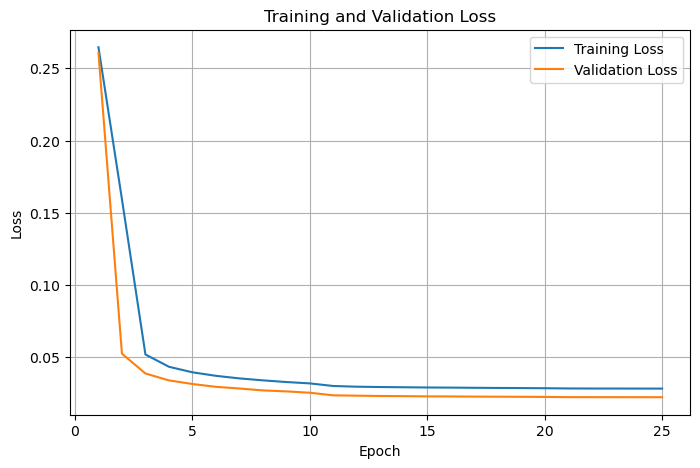

In [68]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [69]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 12.58s, Train Loss: 0.2186, Train Accuracy: 93.57%, Val Accuracy: 97.74%, LR: 0.001000
Epoch [2/15], Time: 12.26s, Train Loss: 0.0995, Train Accuracy: 96.87%, Val Accuracy: 97.99%, LR: 0.001000
Epoch [3/15], Time: 12.70s, Train Loss: 0.0829, Train Accuracy: 97.38%, Val Accuracy: 98.39%, LR: 0.001000
Epoch [4/15], Time: 12.53s, Train Loss: 0.0681, Train Accuracy: 97.81%, Val Accuracy: 98.19%, LR: 0.001000
Epoch [5/15], Time: 12.49s, Train Loss: 0.0605, Train Accuracy: 98.05%, Val Accuracy: 98.28%, LR: 0.001000
Epoch [6/15], Time: 12.34s, Train Loss: 0.0527, Train Accuracy: 98.26%, Val Accuracy: 98.48%, LR: 0.001000
Epoch [7/15], Time: 12.41s, Train Loss: 0.0501, Train Accuracy: 98.41%, Val Accuracy: 98.47%, LR: 0.001000
Epoch [8/15], Time: 12.58s, Train Loss: 0.0483, Train Accuracy: 98.39%, Val Accuracy: 98.55%, LR: 0.001000
Epoch [9/15], Time: 11.99s, Train Loss: 0.0404, Train Accuracy: 98.70%, Val Accuracy: 98.47%, LR: 0.001000
Epoch [10/15], Time: 13.47s, Train Lo

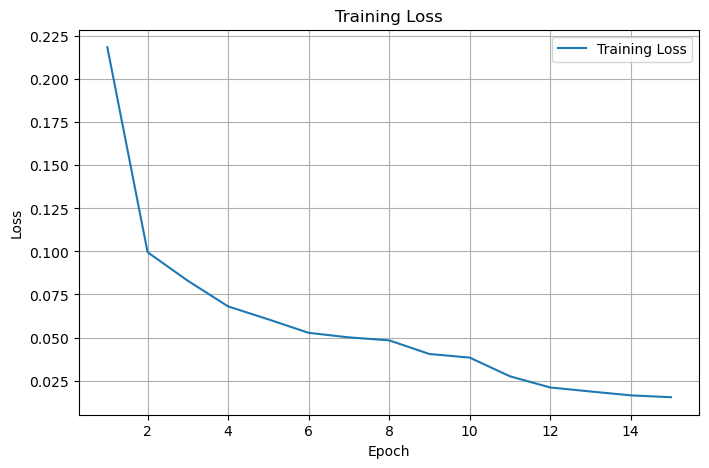

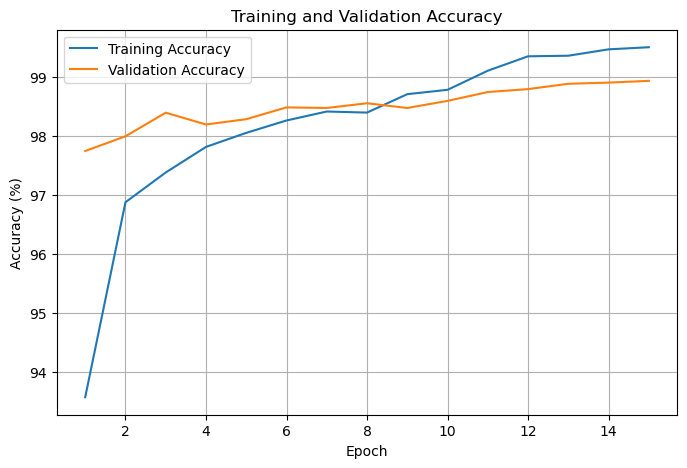

In [70]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [71]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 98.82%


## 1.2.2

In [11]:
# Model initialization
model = MNISTClassifyingAutoencoder(latent_dim=128).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=15,
                       learning_rate=1e-4)

Epoch [1/15], Time: 10.17s, Train Loss: 0.3248, Train Accuracy: 91.08%, Val Accuracy: 96.77%, LR: 0.000100
Epoch [2/15], Time: 9.94s, Train Loss: 0.0965, Train Accuracy: 97.21%, Val Accuracy: 97.80%, LR: 0.000100
Epoch [3/15], Time: 9.78s, Train Loss: 0.0624, Train Accuracy: 98.12%, Val Accuracy: 98.05%, LR: 0.000100
Epoch [4/15], Time: 9.81s, Train Loss: 0.0447, Train Accuracy: 98.61%, Val Accuracy: 98.25%, LR: 0.000100
Epoch [5/15], Time: 9.91s, Train Loss: 0.0331, Train Accuracy: 98.95%, Val Accuracy: 98.30%, LR: 0.000100
Epoch [6/15], Time: 9.90s, Train Loss: 0.0266, Train Accuracy: 99.19%, Val Accuracy: 98.63%, LR: 0.000100
Epoch [7/15], Time: 10.18s, Train Loss: 0.0203, Train Accuracy: 99.39%, Val Accuracy: 98.57%, LR: 0.000100
Epoch [8/15], Time: 9.76s, Train Loss: 0.0171, Train Accuracy: 99.48%, Val Accuracy: 98.50%, LR: 0.000100
Epoch [9/15], Time: 9.84s, Train Loss: 0.0141, Train Accuracy: 99.54%, Val Accuracy: 98.60%, LR: 0.000100
Epoch [10/15], Time: 9.87s, Train Loss: 0.01

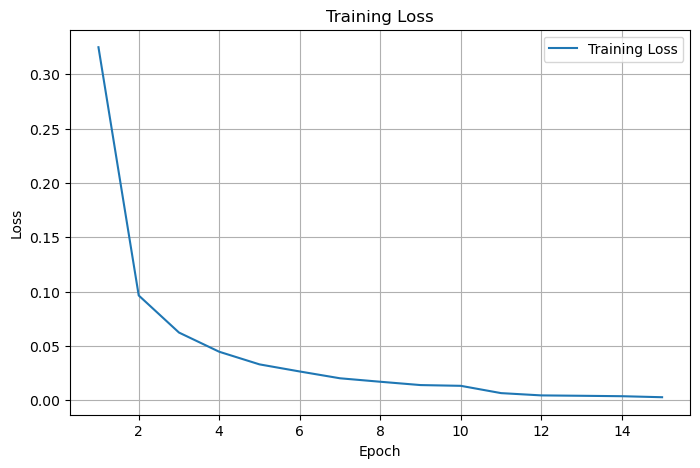

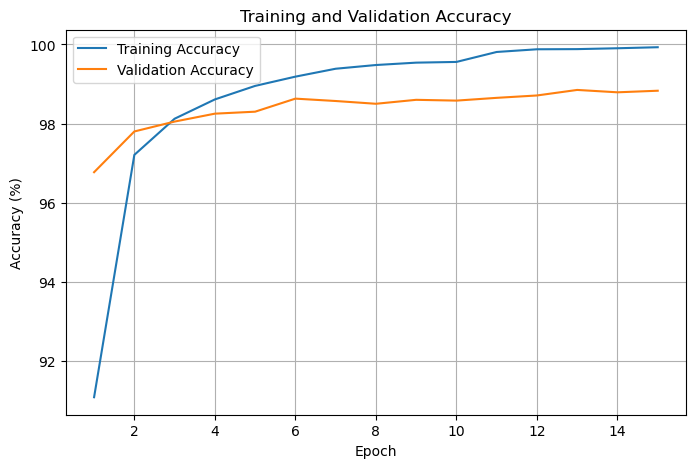

In [12]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [13]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=mnist_test_loader)

Test Accuracy: 98.71%


## 1.2.3

## Data preparation

In [33]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.1307], std=[0.3081])
])


train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [34]:
train_size = 50_000
val_size = 10_000
batch_size = 1024


train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# images, labels = next(iter(mnist_train_loader))
# print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!


In [35]:
model = MnistSimCLR(latent_dim=128,dropout_prob=0.1,temperature = 0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-3)


Epoch [1/25], Time: 7.81s, Train Loss: 7.6092, Val Loss: 7.3809, LR: 0.001000
Epoch [2/25], Time: 7.23s, Train Loss: 7.4026, Val Loss: 6.8395, LR: 0.001000
Epoch [3/25], Time: 7.42s, Train Loss: 7.2519, Val Loss: 6.5323, LR: 0.001000
Epoch [4/25], Time: 7.20s, Train Loss: 6.8513, Val Loss: 5.3621, LR: 0.001000
Epoch [5/25], Time: 7.04s, Train Loss: 6.5302, Val Loss: 5.1067, LR: 0.001000
Epoch [6/25], Time: 7.27s, Train Loss: 6.2887, Val Loss: 4.9205, LR: 0.001000
Epoch [7/25], Time: 7.67s, Train Loss: 6.0144, Val Loss: 4.6784, LR: 0.001000
Epoch [8/25], Time: 7.35s, Train Loss: 5.5087, Val Loss: 4.1851, LR: 0.001000
Epoch [9/25], Time: 7.65s, Train Loss: 5.2860, Val Loss: 3.8857, LR: 0.001000
Epoch [10/25], Time: 7.84s, Train Loss: 5.1993, Val Loss: 3.8105, LR: 0.000100
Epoch [11/25], Time: 7.51s, Train Loss: 4.8253, Val Loss: 3.6537, LR: 0.000100
Epoch [12/25], Time: 7.56s, Train Loss: 4.6502, Val Loss: 3.5627, LR: 0.000100
Epoch [13/25], Time: 7.68s, Train Loss: 4.7014, Val Loss: 3.5

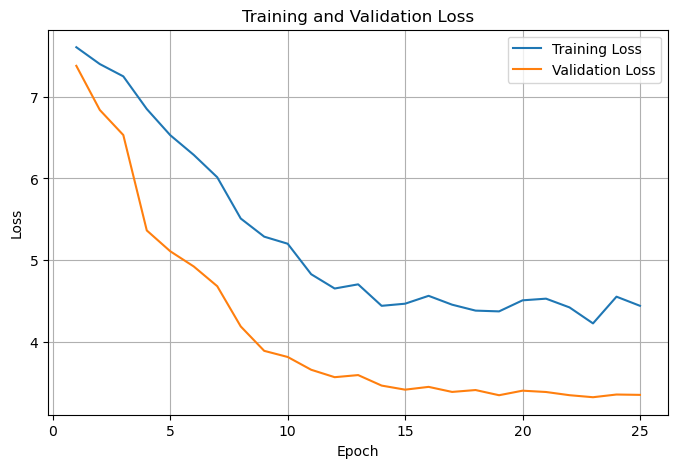

In [36]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [37]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader = mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 7.60s, Train Loss: 0.6736, Train Accuracy: 79.85%, Val Accuracy: 91.15%, LR: 0.001000
Epoch [2/15], Time: 8.00s, Train Loss: 0.2674, Train Accuracy: 91.85%, Val Accuracy: 93.32%, LR: 0.001000
Epoch [3/15], Time: 7.77s, Train Loss: 0.2091, Train Accuracy: 93.45%, Val Accuracy: 94.77%, LR: 0.001000
Epoch [4/15], Time: 8.16s, Train Loss: 0.1840, Train Accuracy: 94.18%, Val Accuracy: 94.44%, LR: 0.001000
Epoch [5/15], Time: 7.91s, Train Loss: 0.1682, Train Accuracy: 94.61%, Val Accuracy: 94.82%, LR: 0.001000
Epoch [6/15], Time: 7.89s, Train Loss: 0.1560, Train Accuracy: 94.97%, Val Accuracy: 95.24%, LR: 0.001000
Epoch [7/15], Time: 7.96s, Train Loss: 0.1482, Train Accuracy: 95.19%, Val Accuracy: 95.65%, LR: 0.001000
Epoch [8/15], Time: 7.92s, Train Loss: 0.1402, Train Accuracy: 95.50%, Val Accuracy: 95.69%, LR: 0.001000
Epoch [9/15], Time: 7.70s, Train Loss: 0.1363, Train Accuracy: 95.54%, Val Accuracy: 95.80%, LR: 0.001000
Epoch [10/15], Time: 8.03s, Train Loss: 0.1324

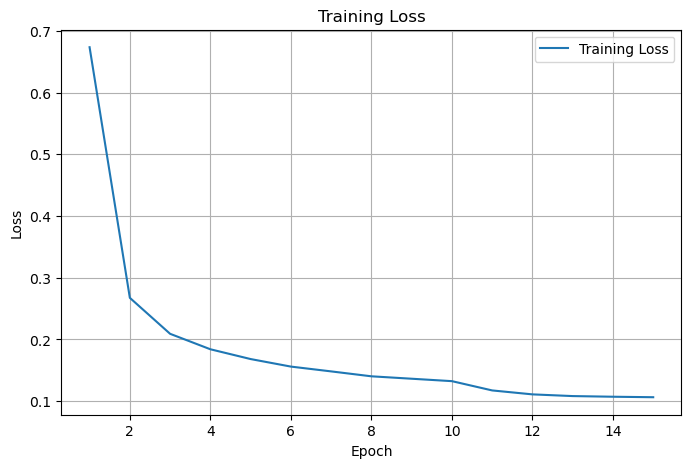

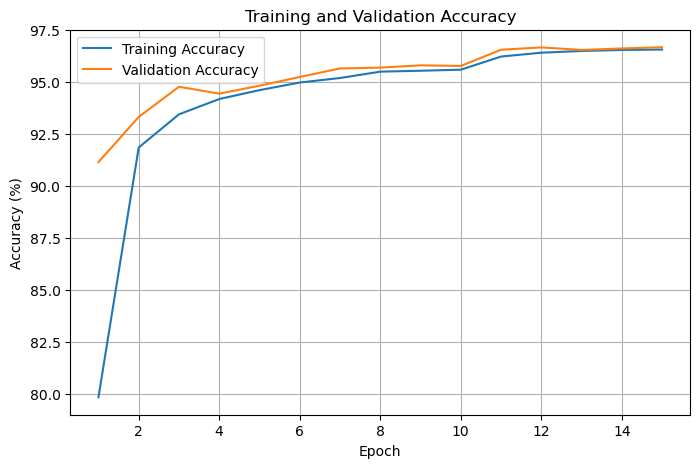

In [38]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [39]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 96.71%


# Cifar10

## Preparing data

In [3]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [4]:
train_size = 40_000
val_size = 10_000

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")

# Define batch size
batch_size = 64

# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 3, 32, 32]), Labels (first 5): tensor([2, 2, 0, 3, 7])


## 1.2.1

In [43]:
model = CIFAR10Autoencoder(latent_dim=128).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate= 1e-3,
                        weight_decay= 1e-3)

Initializing weights ....
Initializing weights DONE
Epoch [1/20], Time: 13.29s, Train Loss: 0.1802, Val Loss: 0.1385 , LR: 0.001000
Epoch [2/20], Time: 13.06s, Train Loss: 0.1313, Val Loss: 0.1175 , LR: 0.001000
Epoch [3/20], Time: 13.28s, Train Loss: 0.1189, Val Loss: 0.1110 , LR: 0.001000
Epoch [4/20], Time: 13.94s, Train Loss: 0.1126, Val Loss: 0.1065 , LR: 0.001000
Epoch [5/20], Time: 12.84s, Train Loss: 0.1083, Val Loss: 0.1035 , LR: 0.001000
Epoch [6/20], Time: 13.05s, Train Loss: 0.1048, Val Loss: 0.1006 , LR: 0.001000
Epoch [7/20], Time: 12.84s, Train Loss: 0.1033, Val Loss: 0.0988 , LR: 0.001000
Epoch [8/20], Time: 13.23s, Train Loss: 0.1019, Val Loss: 0.0978 , LR: 0.001000
Epoch [9/20], Time: 12.74s, Train Loss: 0.1008, Val Loss: 0.0986 , LR: 0.001000
Epoch [10/20], Time: 12.89s, Train Loss: 0.1000, Val Loss: 0.0963 , LR: 0.000100
Epoch [11/20], Time: 13.03s, Train Loss: 0.0966, Val Loss: 0.0938 , LR: 0.000100
Epoch [12/20], Time: 12.94s, Train Loss: 0.0962, Val Loss: 0.0938 

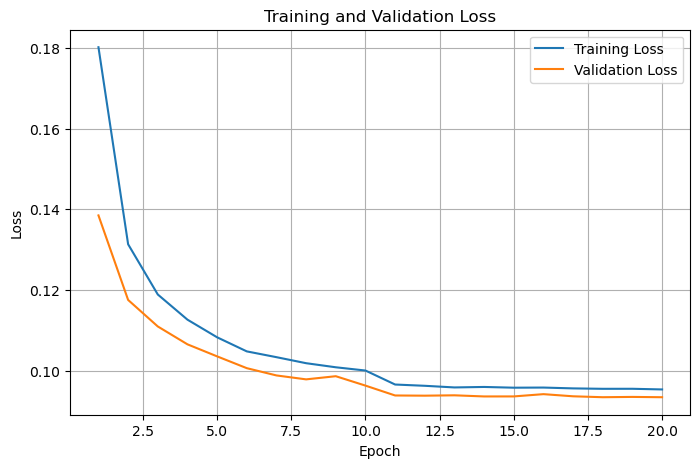

In [44]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [45]:
for param in model.encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
pretrained_encoder = model.encoder
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=30, 
                                                                           learning_rate=1e-3)

Epoch [1/30], Time: 12.31s, Train Loss: 1.6487, Train Accuracy: 41.13%, Val Accuracy: 47.77%, LR: 0.001000
Epoch [2/30], Time: 12.38s, Train Loss: 1.4448, Train Accuracy: 48.53%, Val Accuracy: 50.99%, LR: 0.001000
Epoch [3/30], Time: 12.63s, Train Loss: 1.3552, Train Accuracy: 51.65%, Val Accuracy: 52.22%, LR: 0.001000
Epoch [4/30], Time: 12.39s, Train Loss: 1.2960, Train Accuracy: 53.74%, Val Accuracy: 53.93%, LR: 0.001000
Epoch [5/30], Time: 12.42s, Train Loss: 1.2508, Train Accuracy: 55.14%, Val Accuracy: 54.90%, LR: 0.001000
Epoch [6/30], Time: 12.45s, Train Loss: 1.2072, Train Accuracy: 57.06%, Val Accuracy: 54.63%, LR: 0.001000
Epoch [7/30], Time: 12.53s, Train Loss: 1.1758, Train Accuracy: 58.02%, Val Accuracy: 55.12%, LR: 0.001000
Epoch [8/30], Time: 12.26s, Train Loss: 1.1466, Train Accuracy: 58.88%, Val Accuracy: 56.14%, LR: 0.001000
Epoch [9/30], Time: 12.14s, Train Loss: 1.1236, Train Accuracy: 60.16%, Val Accuracy: 56.36%, LR: 0.001000
Epoch [10/30], Time: 12.42s, Train Lo

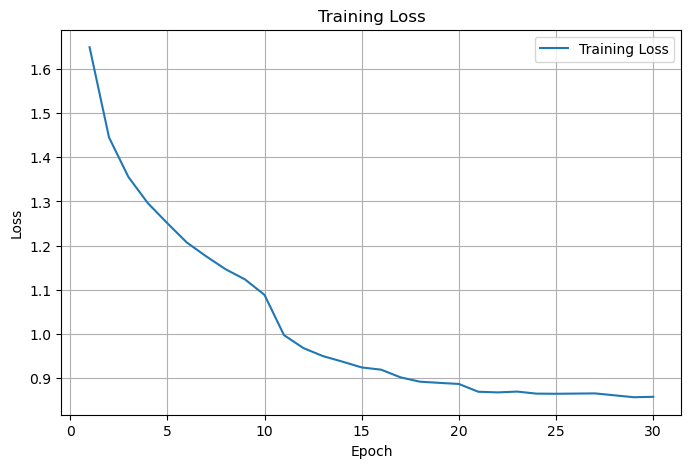

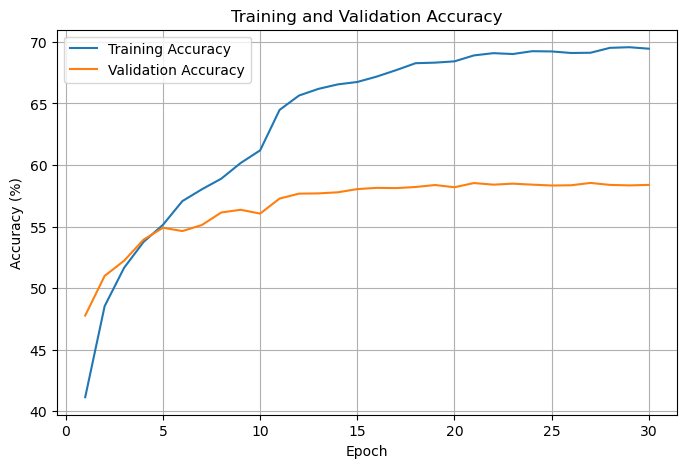

In [46]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [47]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

Test Accuracy: 58.71%


## 1.2.2

In [53]:
# Model initialization
model = CIFAR10ClassifyingAutoencoder(latent_dim=128).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= c10_train_loader,
                                                                         val_loader=c10_val_loader,
                                                                         num_epochs=25,
                                                                         learning_rate=1e-3,
                                                                         weight_decay= 1e-3)

Initializing weights ....
Initializing weights DONE
Epoch [1/25], Time: 13.17s, Train Loss: 1.4566, Train Accuracy: 47.39%, Val Accuracy: 56.96%, LR: 0.001000
Epoch [2/25], Time: 12.66s, Train Loss: 1.1067, Train Accuracy: 60.88%, Val Accuracy: 62.57%, LR: 0.001000
Epoch [3/25], Time: 12.50s, Train Loss: 0.9225, Train Accuracy: 67.93%, Val Accuracy: 66.01%, LR: 0.001000
Epoch [4/25], Time: 12.94s, Train Loss: 0.7753, Train Accuracy: 73.05%, Val Accuracy: 67.49%, LR: 0.001000
Epoch [5/25], Time: 12.59s, Train Loss: 0.6521, Train Accuracy: 77.72%, Val Accuracy: 68.10%, LR: 0.001000
Epoch [6/25], Time: 12.83s, Train Loss: 0.5448, Train Accuracy: 81.17%, Val Accuracy: 67.87%, LR: 0.001000
Epoch [7/25], Time: 12.73s, Train Loss: 0.4469, Train Accuracy: 84.71%, Val Accuracy: 68.05%, LR: 0.001000
Epoch [8/25], Time: 13.05s, Train Loss: 0.3758, Train Accuracy: 87.25%, Val Accuracy: 67.49%, LR: 0.001000
Epoch [9/25], Time: 13.46s, Train Loss: 0.3037, Train Accuracy: 89.83%, Val Accuracy: 68.83%

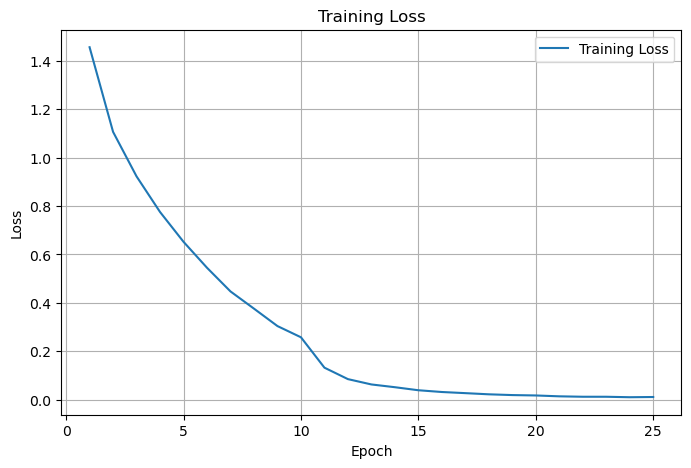

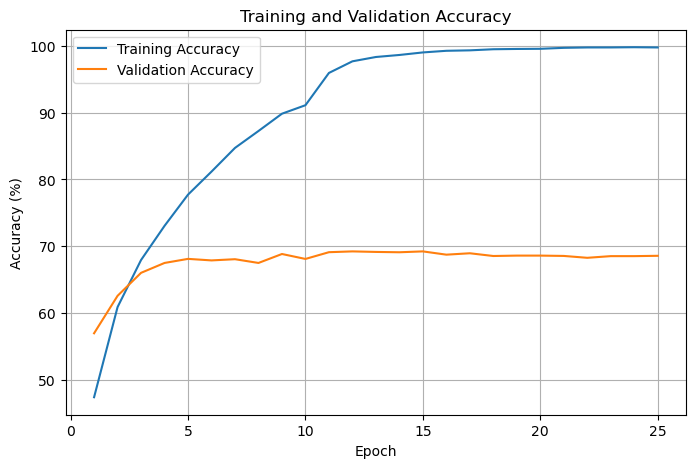

In [54]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [55]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=c10_test_loader)

Test Accuracy: 69.46%


## 1.2.3

# Data Preparation

In [3]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), #moved to model code for color jitter compatability
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [4]:
train_size = 40_000
val_size = 10_000
batch_size = 512

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")



# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([512, 3, 32, 32]), Labels (first 5): tensor([7, 5, 1, 4, 1])


In [5]:
model = Cifar10SimCLR(latent_dim=128,
                      dropout_prob=0.1,
                      temperature=0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate=1e-3,
                        weight_decay= 1e-3)

Initializing weights ....
Initializing weights DONE
Epoch [1/20], Time: 65.06s, Train Loss: 2.6630, Val Loss: 0.7414, LR: 0.001000


KeyboardInterrupt: 

In [ ]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [ ]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=20, 
                                                                           learning_rate=1e-3)

In [ ]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)